<a href="https://colab.research.google.com/github/Ramubala/image-classification/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
! git clone https://github.com/Ramubala/image-classification.git

Cloning into 'image-classification'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), 5.28 KiB | 5.28 MiB/s, done.


In [19]:
%ls
%cd image-classification

data/                  Image_classification.ipynb  tut1-model.pt
image-classification/  README.md
/content/image-classification/image-classification


In [20]:
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
import numpy as np

In [21]:
dir = 'data'
#!rm -rf data
data = datasets.MNIST(root=dir, train=True, download =True, transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]))
test_data = datasets.MNIST(root=dir, train=False, download =True, transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [40]:
data[0][0].shape

torch.Size([1, 28, 28])

In [22]:
type(data), len(data), len(test_data)

(torchvision.datasets.mnist.MNIST, 60000, 10000)

In [23]:
train_data, valid_data = torch.utils.data.random_split(data, [50000, 10000])

In [24]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64)

In [25]:
class Simple_nn(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=784,out_features=250)
    self.layer2 = nn.Linear(in_features=250,out_features=100)
    self.layer3 = nn.Linear(in_features=100,out_features=10)
  
  def forward(self, input):
    layer1_output = torch.nn.functional.relu(self.layer1(input))
    layer2_output = torch.nn.functional.relu(self.layer2(layer1_output))
    layer3_output = torch.nn.functional.softmax(self.layer3(layer2_output),dim=1)
    return layer3_output,layer2_output

In [26]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple_nn().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [27]:
def get_accuracy(y_pred,y_actual):
  y_pred = torch.argmax(y_pred,1)
  accuracy = (y_pred == y_actual).sum()
  return 100*accuracy/y_pred.shape[0]

In [28]:
def train_model(dataloader,model):
  train_loss=0
  train_accuracy = 0
  for input, y in iter(dataloader):
    optimizer.zero_grad()
    batch_size = input.shape[0]
    image_size = input.shape[2]*input.shape[3]
    input = input.squeeze(1).reshape(batch_size,image_size).to(device)
    output, h2 = model(input)
    loss = criterion(output, y.to(device))
    accuracy = get_accuracy(output,y.to(device))
    loss.backward()
    train_loss+=loss
    train_accuracy+=accuracy
    optimizer.step()
  train_loss=train_loss/len(dataloader)
  train_accuracy=train_accuracy/len(dataloader)
  return train_loss,train_accuracy

In [29]:
def eval_model(dataloader,model):
    val_loss=0
    val_accuracy = 0  
    with torch.no_grad():
        for input, y in iter(dataloader):
          batch_size = input.shape[0]
          image_size = input.shape[2]*input.shape[3]
          input = input.squeeze(1).reshape(batch_size,image_size).to(device)
          output, h2 = model(input)
          loss = criterion(output, y.to(device))
          accuracy = get_accuracy(output, y.to(device))
          val_loss+=loss
          val_accuracy+=accuracy
        val_loss=val_loss/len(dataloader)
        val_accuracy=val_accuracy/len(dataloader)
        return val_loss,val_accuracy

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
N_epochs =30
import time
min_val_loss= float('inf')
for i in range(N_epochs):
  start_time = time.monotonic()
  train_loss, train_accuracy = train_model(train_dataloader, model)
  val_loss, val_accuracy = eval_model(val_dataloader, model)
  if val_loss <min_val_loss:
    min_val_loss = val_loss
    torch.save(model.state_dict(), 'tut1-model.pt')
  end_time = time.monotonic()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | Train loss: {train_loss:02}, Train accuracy: {train_accuracy:02}, Val accuracy: {val_accuracy:02},  Val loss: {val_loss:02}')

Epoch: 01 | Epoch Time: 0m 14s | Train loss: 1.5745612382888794, Train accuracy: 89.6799087524414, Val accuracy: 94.79498291015625,  Val loss: 1.515947937965393
Epoch: 02 | Epoch Time: 0m 15s | Train loss: 1.5143235921859741, Train accuracy: 94.8948974609375, Val accuracy: 95.45183563232422,  Val loss: 1.5082629919052124
Epoch: 03 | Epoch Time: 0m 14s | Train loss: 1.5030620098114014, Train accuracy: 95.91192626953125, Val accuracy: 95.78025817871094,  Val loss: 1.5042152404785156
Epoch: 04 | Epoch Time: 0m 14s | Train loss: 1.4964752197265625, Train accuracy: 96.5233383178711, Val accuracy: 96.14849090576172,  Val loss: 1.4996066093444824
Epoch: 05 | Epoch Time: 0m 14s | Train loss: 1.4922268390655518, Train accuracy: 96.98489379882812, Val accuracy: 96.43710327148438,  Val loss: 1.4972500801086426
Epoch: 06 | Epoch Time: 0m 14s | Train loss: 1.4906716346740723, Train accuracy: 97.07080841064453, Val accuracy: 95.63097381591797,  Val loss: 1.505174994468689
Epoch: 07 | Epoch Time: 0m 

In [32]:
eval_model(test_dataloader, model)

(tensor(1.4900, device='cuda:0'), tensor(97.1139, device='cuda:0'))

In [33]:
import matplotlib.pyplot as plt

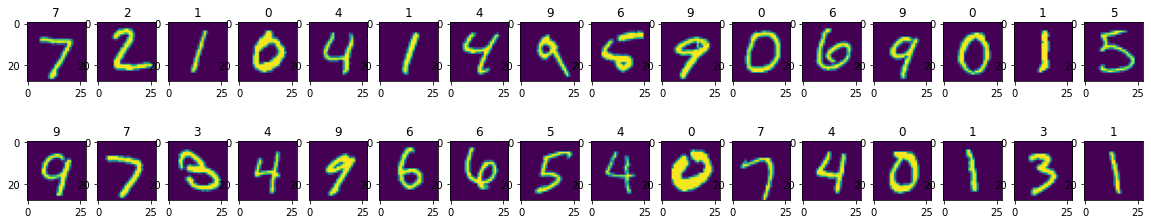

In [34]:
for input, y in iter(test_dataloader):
    input1 = input.squeeze(1).reshape(64, 784).to(device)
    res = model(input1)
    res = res[0].argmax(dim=1).cpu().detach().numpy()
    fig,ax = plt.subplots(2,16,figsize=(20,4))
    for i in range(32):
          ax[int(i/16)][i%16].imshow(input.numpy().squeeze()[i])
          ax[int(i/16)][i%16].set_title(res[i])
    break